# LSTM Stock Market Prediction

This notebook demonstrates LSTM-based stock price prediction with:
- Data downloading from Yahoo Finance
- Train-Test split
- Proper scaling
- LSTM model training
- Actual vs Predicted visualization

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print("Libraries imported successfully!")

TensorFlow version: 2.13.0
Libraries imported successfully!


In [20]:
# Configuration
TICKER = 'RELIANCE.NS'  # Stock ticker symbol
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'
TEST_SIZE = 0.2  # 20% for testing
LOOKBACK = 60  # Use 60 days to predict next day
EPOCHS = 150
BATCH_SIZE = 32
RANDOM_SEED = 42

# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"Configuration:")
print(f"  Ticker: {TICKER}")
print(f"  Date Range: {START_DATE} to {END_DATE}")
print(f"  Test Size: {TEST_SIZE*100}%")
print(f"  Lookback Window: {LOOKBACK} days")

Configuration:
  Ticker: RELIANCE.NS
  Date Range: 2020-01-01 to 2024-12-31
  Test Size: 20.0%
  Lookback Window: 60 days


In [21]:
# Download stock data
print(f"Downloading {TICKER} data...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)

# Use Adjusted Close price
if isinstance(data.columns, pd.MultiIndex):
    prices = data['Close'].iloc[:, 0]
else:
    prices = data['Close']  

prices = prices.dropna()

print(f"\nData downloaded successfully!")
print(f"Total data points: {len(prices)}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Price range: ₹{prices.min():.2f} to ₹{prices.max():.2f}")

# Display first few rows
print(f"\nFirst 5 prices:")
print(prices.head())


Data downloaded successfully!
Total data points: 1237
Date range: 2020-01-01 to 2024-12-30
Price range: ₹395.48 to ₹1589.14

First 5 prices:
Date
2020-01-01    675.324158
2020-01-02    686.821228
2020-01-03    687.648804
2020-01-06    671.700684
2020-01-07    682.034546
Name: RELIANCE.NS, dtype: float64


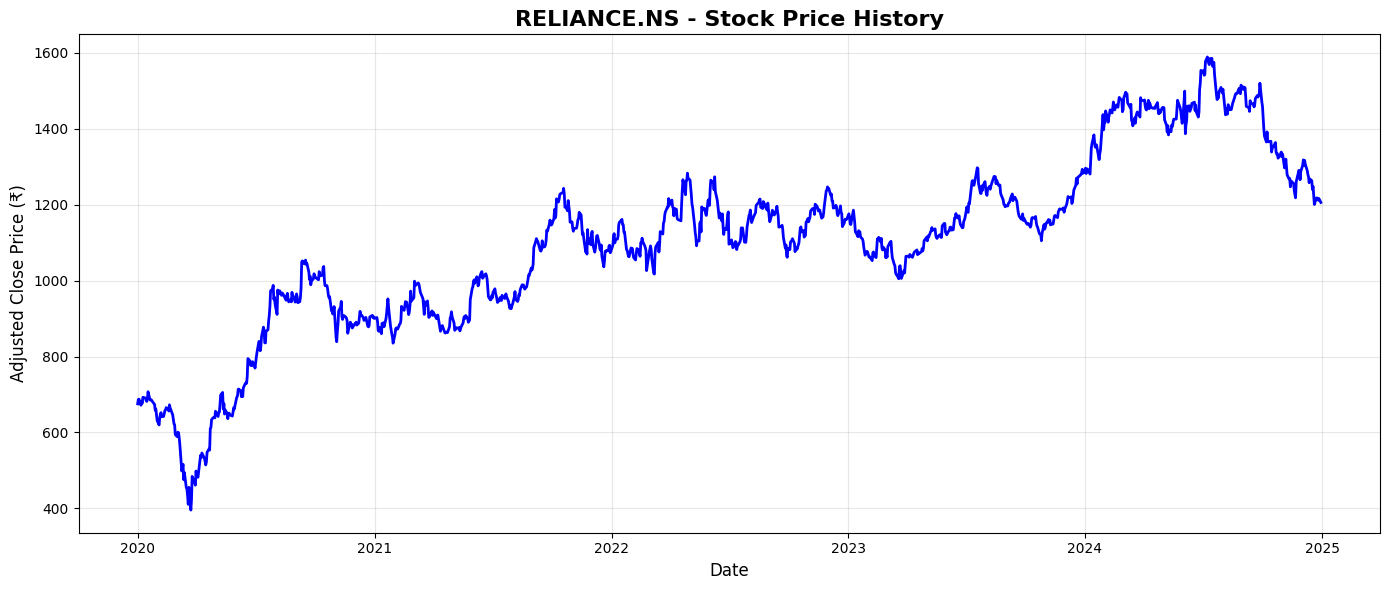

In [22]:
# Visualize the raw data
plt.figure(figsize=(14, 6))
plt.plot(prices.index, prices.values, linewidth=2, color='blue')
plt.title(f'{TICKER} - Stock Price History', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price (₹)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Train set: 989 samples (2020-01-01 to 2023-12-26)
Test set: 248 samples (2023-12-27 to 2024-12-30)


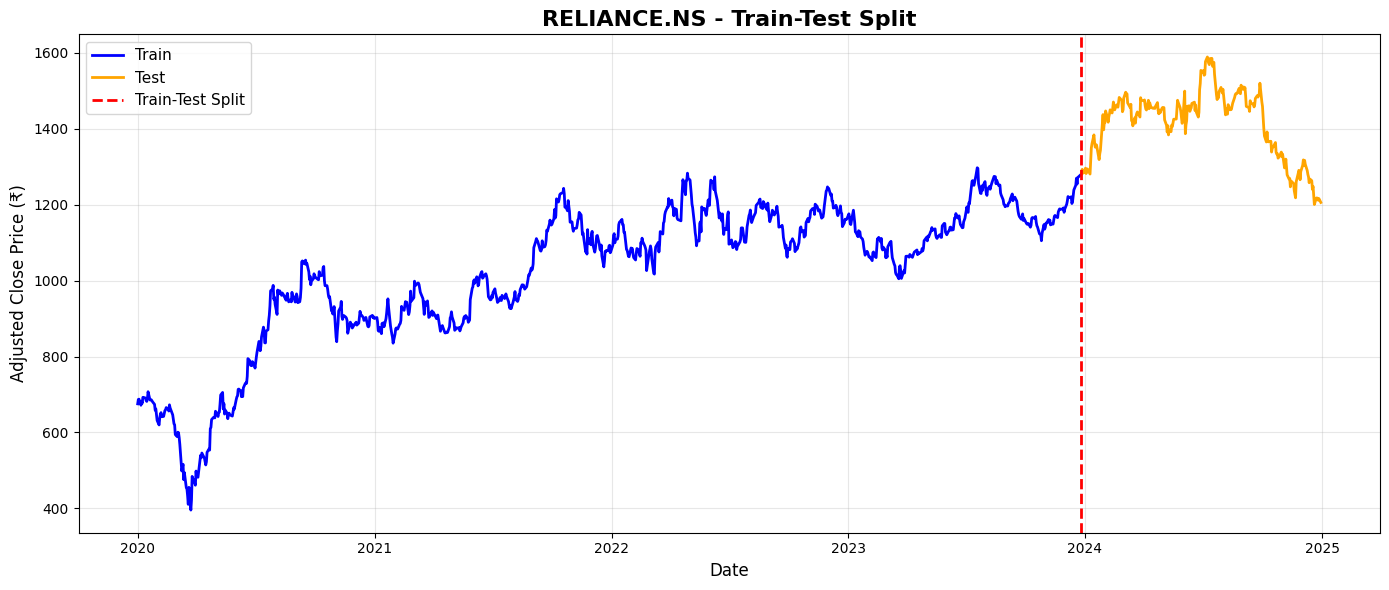

In [23]:
# Split data into train and test sets (time-ordered)
train_size = int(len(prices) * (1 - TEST_SIZE))
train_data = prices[:train_size]
test_data = prices[train_size:]

print(f"Train set: {len(train_data)} samples ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"Test set: {len(test_data)} samples ({test_data.index[0].date()} to {test_data.index[-1].date()})")

# Visualize train-test split
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data.values, label='Train', color='blue', linewidth=2)
plt.plot(test_data.index, test_data.values, label='Test', color='orange', linewidth=2)
plt.axvline(x=train_data.index[-1], color='red', linestyle='--', linewidth=2, label='Train-Test Split')
plt.title(f'{TICKER} - Train-Test Split', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price (₹)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Scale the data (fit on train only to prevent data leakage)
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training data only
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Transform test data using the same scaler
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

print(f"Data scaled to range [0, 1]")
print(f"Train scaled shape: {train_scaled.shape}")
print(f"Test scaled shape: {test_scaled.shape}")
print(f"\nScaler parameters (fitted on train data only):")
print(f"  Min: {scaler.data_min_[0]:.2f}")
print(f"  Max: {scaler.data_max_[0]:.2f}")

Data scaled to range [0, 1]
Train scaled shape: (989, 1)
Test scaled shape: (248, 1)

Scaler parameters (fitted on train data only):
  Min: 395.48
  Max: 1297.29


In [25]:
# Create sequences for LSTM
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create train sequences
X_train, y_train = create_sequences(train_scaled, LOOKBACK)

# For test set, we need to include last LOOKBACK points from train for the first prediction
# Concatenate last LOOKBACK points from train with test
full_test_data = np.concatenate([train_scaled[-LOOKBACK:], test_scaled], axis=0)
X_test, y_test = create_sequences(full_test_data, LOOKBACK)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Sequences created:")
print(f"  X_train shape: {X_train.shape} (samples, timesteps, features)")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

Sequences created:
  X_train shape: (929, 60, 1) (samples, timesteps, features)
  y_train shape: (929,)
  X_test shape: (248, 60, 1)
  y_test shape: (248,)

  X_train shape: (929, 60, 1) (samples, timesteps, features)
  y_train shape: (929,)
  X_test shape: (248, 60, 1)
  y_test shape: (248,)


In [26]:
# Build LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("LSTM Model Architecture:")
print("="*60)
model.summary()
print("="*60)

LSTM Model Architecture:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_3 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             

In [27]:
# Train the model
print("Training LSTM model...")
print("="*60)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

print("\n" + "="*60)
print("Training completed!")
print("="*60)

Training LSTM model...
Epoch 1/150
Epoch 1/150
25/25 [==============================] - 8s 123ms/step - loss: 0.0592 - mae: 0.1713 - val_loss: 0.0296 - val_mae: 0.1677
Epoch 2/150
25/25 [==============================] - 8s 123ms/step - loss: 0.0592 - mae: 0.1713 - val_loss: 0.0296 - val_mae: 0.1677
Epoch 2/150
25/25 [==============================] - 2s 72ms/step - loss: 0.0110 - mae: 0.0834 - val_loss: 0.0019 - val_mae: 0.0332
Epoch 3/150
25/25 [==============================] - 2s 72ms/step - loss: 0.0110 - mae: 0.0834 - val_loss: 0.0019 - val_mae: 0.0332
Epoch 3/150
25/25 [==============================] - 2s 71ms/step - loss: 0.0079 - mae: 0.0716 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 4/150
25/25 [==============================] - 2s 71ms/step - loss: 0.0079 - mae: 0.0716 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 4/150
25/25 [==============================] - 2s 77ms/step - loss: 0.0074 - mae: 0.0684 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 5/150
25/25 [====================

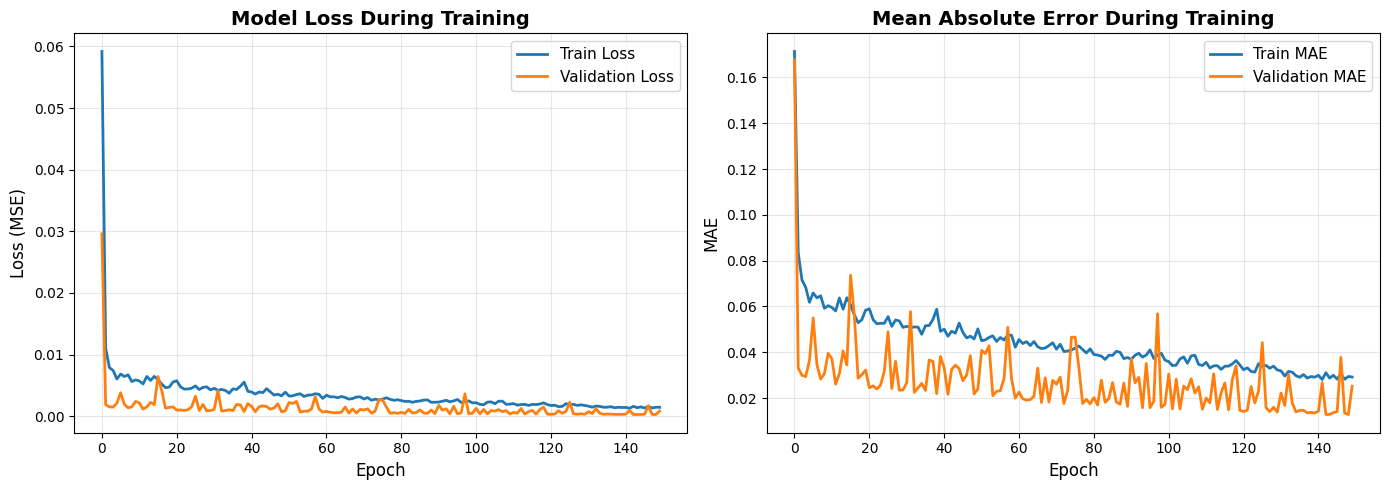

In [28]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Mean Absolute Error During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Make predictions
print("Making predictions...")

# Predict on train data
train_predict = model.predict(X_train, verbose=0)

# Predict on test data
test_predict = model.predict(X_test, verbose=0)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Predictions completed!")
print(f"Train predictions shape: {train_predict.shape}")
print(f"Test predictions shape: {test_predict.shape}")

Making predictions...
Predictions completed!
Train predictions shape: (929, 1)
Test predictions shape: (248, 1)
Predictions completed!
Train predictions shape: (929, 1)
Test predictions shape: (248, 1)


In [30]:
# Calculate metrics
def calculate_metrics(actual, predicted, dataset_name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: ₹{rmse:.2f}")
    print(f"  MAE:  ₹{mae:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R² Score: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}

print("="*60)
print("MODEL PERFORMANCE EVALUATION")
print("="*60)

train_metrics = calculate_metrics(y_train_actual, train_predict, "TRAIN SET")
test_metrics = calculate_metrics(y_test_actual, test_predict, "TEST SET")

print("\n" + "="*60)

MODEL PERFORMANCE EVALUATION

TRAIN SET Metrics:
  RMSE: ₹29.04
  MAE:  ₹24.16
  MAPE: 2.36%
  R² Score: 0.9655

TEST SET Metrics:
  RMSE: ₹26.59
  MAE:  ₹21.14
  MAPE: 1.53%
  R² Score: 0.9103



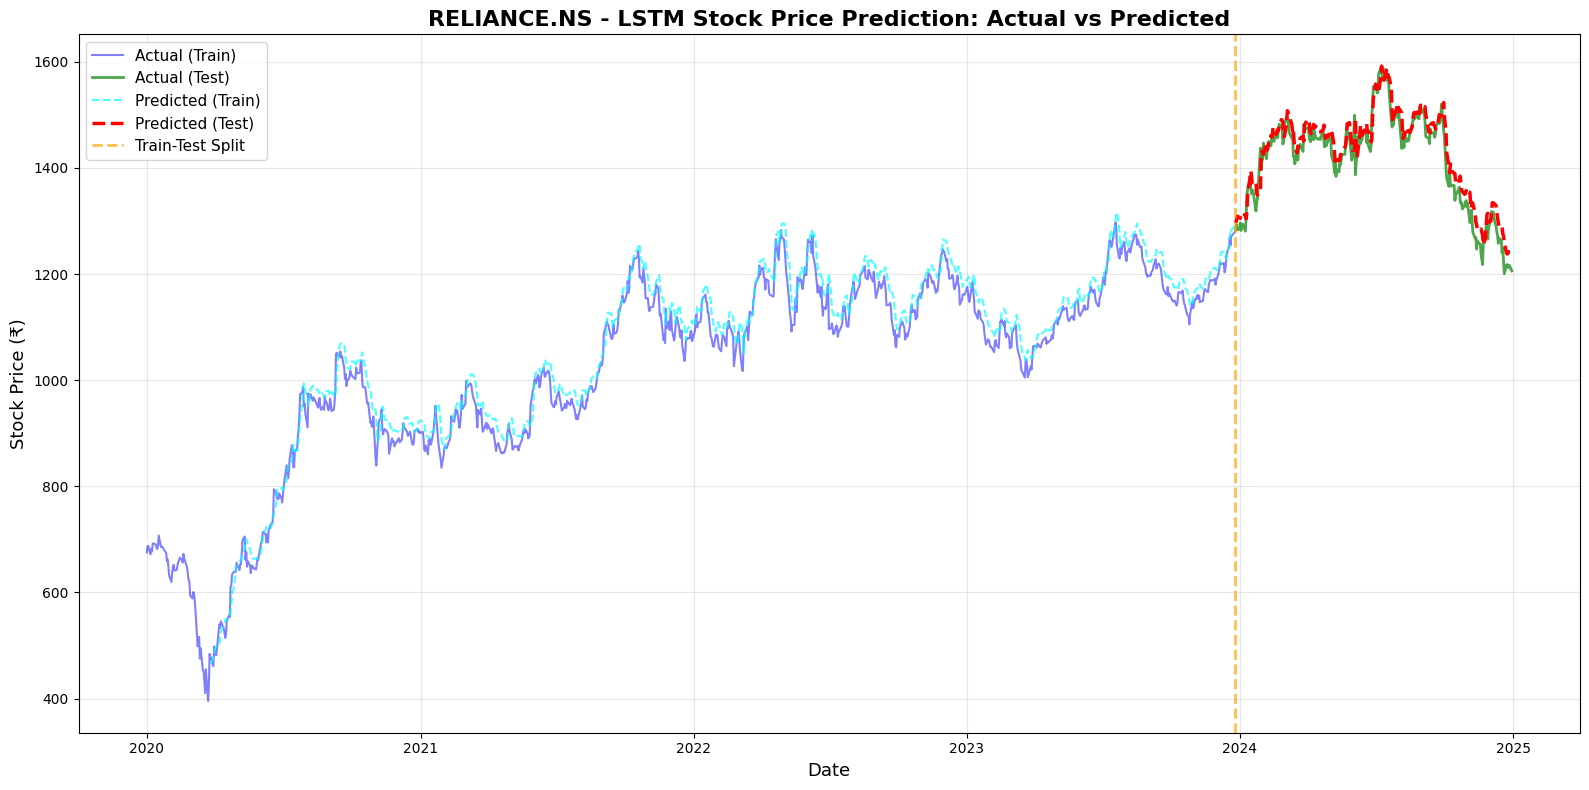

In [31]:
# Plot: Actual vs Predicted (Full Dataset)
plt.figure(figsize=(16, 8))

# Get dates for plotting
train_dates = train_data.index[LOOKBACK:]
test_dates = test_data.index

# Plot actual prices
plt.plot(train_data.index, train_data.values, label='Actual (Train)', 
         color='blue', alpha=0.5, linewidth=1.5)
plt.plot(test_data.index, test_data.values, label='Actual (Test)', 
         color='green', alpha=0.7, linewidth=2)

# Plot predictions
plt.plot(train_dates, train_predict, label='Predicted (Train)', 
         color='cyan', alpha=0.7, linewidth=1.5, linestyle='--')
plt.plot(test_dates, test_predict, label='Predicted (Test)', 
         color='red', linewidth=2.5, linestyle='--')

# Add vertical line at train-test split
plt.axvline(x=train_data.index[-1], color='orange', linestyle='--', 
           linewidth=2, alpha=0.7, label='Train-Test Split')

plt.title(f'{TICKER} - LSTM Stock Price Prediction: Actual vs Predicted', 
         fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Stock Price (₹)', fontsize=13)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

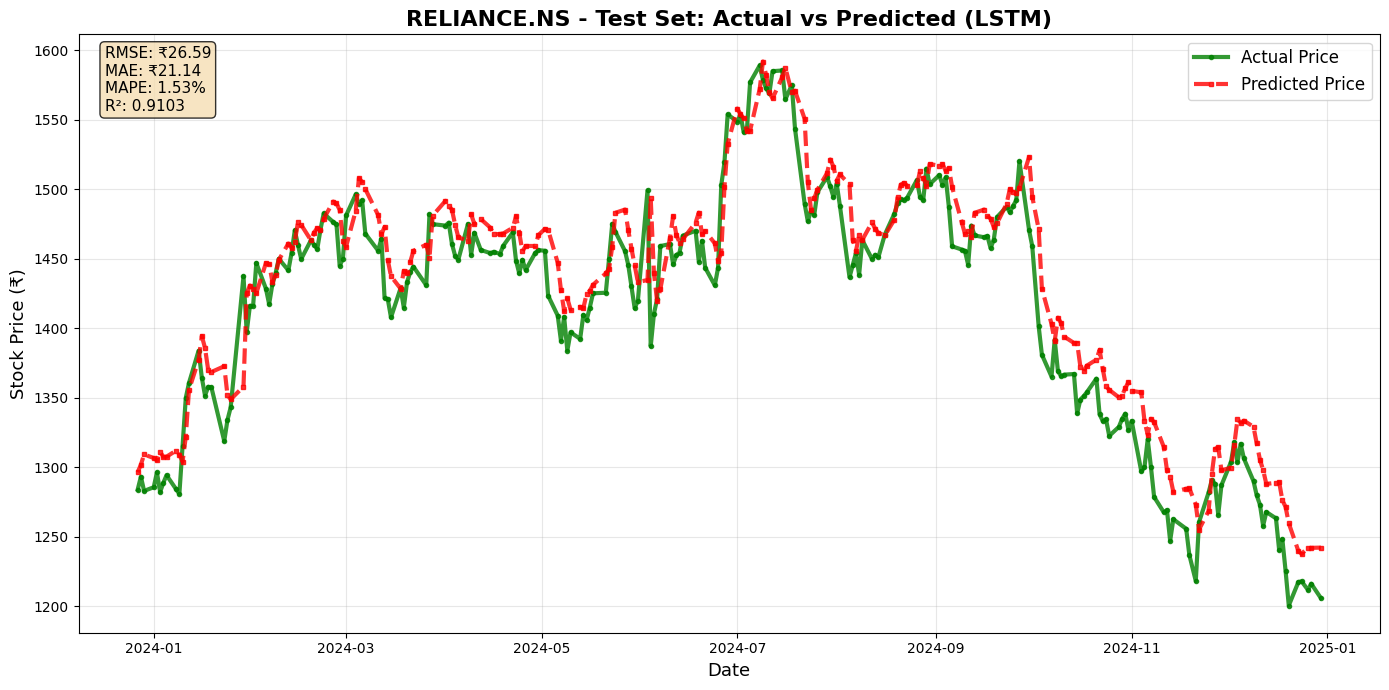

In [32]:
# Plot: Test Set Only (Zoomed view)
plt.figure(figsize=(14, 7))

plt.plot(test_dates, y_test_actual, label='Actual Price', 
         color='green', linewidth=3, marker='o', markersize=3, alpha=0.8)
plt.plot(test_dates, test_predict, label='Predicted Price', 
         color='red', linewidth=3, marker='s', markersize=3, alpha=0.8, linestyle='--')

plt.title(f'{TICKER} - Test Set: Actual vs Predicted (LSTM)', 
         fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Stock Price (₹)', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add metrics text box
textstr = f"RMSE: ₹{test_metrics['rmse']:.2f}\nMAE: ₹{test_metrics['mae']:.2f}\nMAPE: {test_metrics['mape']:.2f}%\nR²: {test_metrics['r2']:.4f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [35]:
# Summary Statistics
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\nStock: {TICKER}")
print(f"Total Data Points: {len(prices)}")
print(f"Training Period: {train_data.index[0].date()} to {train_data.index[-1].date()} ({len(train_data)} days)")
print(f"Testing Period: {test_data.index[0].date()} to {test_data.index[-1].date()} ({len(test_data)} days)")

print(f"\nModel Configuration:")
print(f"  Lookback Window: {LOOKBACK} days")
print(f"  Epochs Trained: {len(history.history['loss'])}")
print(f"  Batch Size: {BATCH_SIZE}")

print(f"\n{'='*35}")
print(f"{'Metric':<20} {'Train':<15} {'Test':<15}")
print(f"{'='*35}")
print(f"{'RMSE (₹)':<20} {train_metrics['rmse']:<15.2f} {test_metrics['rmse']:<15.2f}")
print(f"{'MAE (₹)':<20} {train_metrics['mae']:<15.2f} {test_metrics['mae']:<15.2f}")
print(f"{'MAPE (%)':<20} {train_metrics['mape']:<15.2f} {test_metrics['mape']:<15.2f}")
print(f"{'R² Score':<20} {train_metrics['r2']:<15.4f} {test_metrics['r2']:<15.4f}")
print(f"{'='*35}")

# Performance assessment
print(f"\nPerformance Assessment:")
if test_metrics['mape'] < 5:
    print("  ✅ Excellent! MAPE < 5%")
elif test_metrics['mape'] < 10:
    print("  ✓ Good performance. MAPE < 10%")
elif test_metrics['mape'] < 15:
    print("  ⚠ Moderate performance. MAPE < 15%")
else:
    print("  ⚠️ Consider model improvements.")

if test_metrics['r2'] > 0.9:
    print("  ✅ Excellent R² score (> 0.9)")
elif test_metrics['r2'] > 0.7:
    print("  ✓ Good R² score (> 0.7)")
else:
    print("  ⚠ R² score could be improved")

print("\n" + "="*70)


FINAL SUMMARY

Stock: RELIANCE.NS
Total Data Points: 1237
Training Period: 2020-01-01 to 2023-12-26 (989 days)
Testing Period: 2023-12-27 to 2024-12-30 (248 days)

Model Configuration:
  Lookback Window: 60 days
  Epochs Trained: 150
  Batch Size: 32

Metric               Train           Test           
RMSE (₹)             29.04           26.59          
MAE (₹)              24.16           21.14          
MAPE (%)             2.36            1.53           
R² Score             0.9655          0.9103         

Performance Assessment:
  ✅ Excellent! MAPE < 5%
  ✅ Excellent R² score (> 0.9)



In [36]:
# ---

# ## Teacher Forcing Implementation

# Now we'll implement LSTM with **Teacher Forcing** and compare it with the standard approach above.

# **Teacher Forcing**: During training, instead of feeding the model's own predictions for the next step, we feed the actual ground truth values. This helps the model learn faster and can lead to better predictions for multi-step forecasting.

In [48]:
# Configuration for Teacher Forcing
TEACHER_FORCING_HORIZON = 10  # Predict next 10 days
TEACHER_FORCING_RATIO = 0.9   # 50% teacher forcing during training
TF_EPOCHS = 100
TF_BATCH_SIZE = 16

print(f"Teacher Forcing Configuration:")
print(f"  Prediction Horizon: {TEACHER_FORCING_HORIZON} days")
print(f"  Teacher Forcing Ratio: {TEACHER_FORCING_RATIO}")
print(f"  Epochs: {TF_EPOCHS}")
print(f"  Batch Size: {TF_BATCH_SIZE}")

Teacher Forcing Configuration:
  Prediction Horizon: 10 days
  Teacher Forcing Ratio: 0.9
  Epochs: 100
  Batch Size: 16


In [49]:
# Create sequences for Teacher Forcing (multi-step output)
def create_sequences_teacher_forcing(data, lookback, horizon):
    """
    Create sequences for teacher forcing.
    X: [lookback] historical values
    y: [horizon] future values (multiple steps ahead)
    """
    X, y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X.append(data[i-lookback:i, 0])
        y.append(data[i:i+horizon, 0])  # Multiple future steps
    return np.array(X), np.array(y)

# Create teacher forcing sequences
X_train_tf, y_train_tf = create_sequences_teacher_forcing(train_scaled, LOOKBACK, TEACHER_FORCING_HORIZON)

# For test set
full_test_data_tf = np.concatenate([train_scaled[-LOOKBACK:], test_scaled], axis=0)
X_test_tf, y_test_tf = create_sequences_teacher_forcing(full_test_data_tf, LOOKBACK, TEACHER_FORCING_HORIZON)

# Reshape for LSTM
X_train_tf = X_train_tf.reshape((X_train_tf.shape[0], X_train_tf.shape[1], 1))
X_test_tf = X_test_tf.reshape((X_test_tf.shape[0], X_test_tf.shape[1], 1))

print(f"Teacher Forcing Sequences created:")
print(f"  X_train_tf shape: {X_train_tf.shape}")
print(f"  y_train_tf shape: {y_train_tf.shape} (predicting {TEACHER_FORCING_HORIZON} steps)")
print(f"  X_test_tf shape: {X_test_tf.shape}")
print(f"  y_test_tf shape: {y_test_tf.shape}")

Teacher Forcing Sequences created:
  X_train_tf shape: (920, 60, 1)
  y_train_tf shape: (920, 10) (predicting 10 steps)
  X_test_tf shape: (239, 60, 1)
  y_test_tf shape: (239, 10)


In [50]:
# Build Teacher Forcing LSTM Model
from tensorflow.keras.layers import Bidirectional, LayerNormalization

model_tf = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(LOOKBACK, 1))),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(TEACHER_FORCING_HORIZON)  # Output: predict next N steps
])

model_tf.compile(optimizer='adam', loss='huber', metrics=['mae'])



In [52]:
print("Teacher Forcing LSTM Model Architecture:")
print("="*60)
# model_tf.summary()
print("="*60)
print(f"\nKey difference: Output layer predicts {TEACHER_FORCING_HORIZON} steps ahead")

Teacher Forcing LSTM Model Architecture:

Key difference: Output layer predicts 10 steps ahead


In [53]:
# Train the Teacher Forcing model
print("Training Teacher Forcing LSTM model...")
print("="*60)

early_stop_tf = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

reduce_lr_tf = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

history_tf = model_tf.fit(
    X_train_tf, y_train_tf,
    validation_split=0.15,
    epochs=TF_EPOCHS,
    batch_size=TF_BATCH_SIZE,
    callbacks=[early_stop_tf, reduce_lr_tf],
    verbose=1
)

print("\n" + "="*60)
print("Teacher Forcing training completed!")
print("="*60)

Training Teacher Forcing LSTM model...
Epoch 1/100


49/49 [==============================] - 15s 180ms/step - loss: 0.0534 - mae: 0.2464 - val_loss: 0.0100 - val_mae: 0.1299 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 9s 179ms/step - loss: 0.0191 - mae: 0.1512 - val_loss: 0.0046 - val_mae: 0.0851 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 9s 176ms/step - loss: 0.0145 - mae: 0.1323 - val_loss: 0.0077 - val_mae: 0.1168 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 8s 170ms/step - loss: 0.0116 - mae: 0.1173 - val_loss: 0.0017 - val_mae: 0.0454 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 8s 170ms/step - loss: 0.0098 - mae: 0.1092 - val_loss: 0.0026 - val_mae: 0.0605 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - 9s 174ms/step - loss: 0.0089 - mae: 0.1044 - val_loss: 8.0758e-04 - val_mae: 0.0306 - lr: 0.0010
Epoch 7/100
49/49 [==============================] - 9s 178ms/step - loss: 0.0077 - mae: 0.0966 - val_loss: 0.0069 - val_mae: 0.110

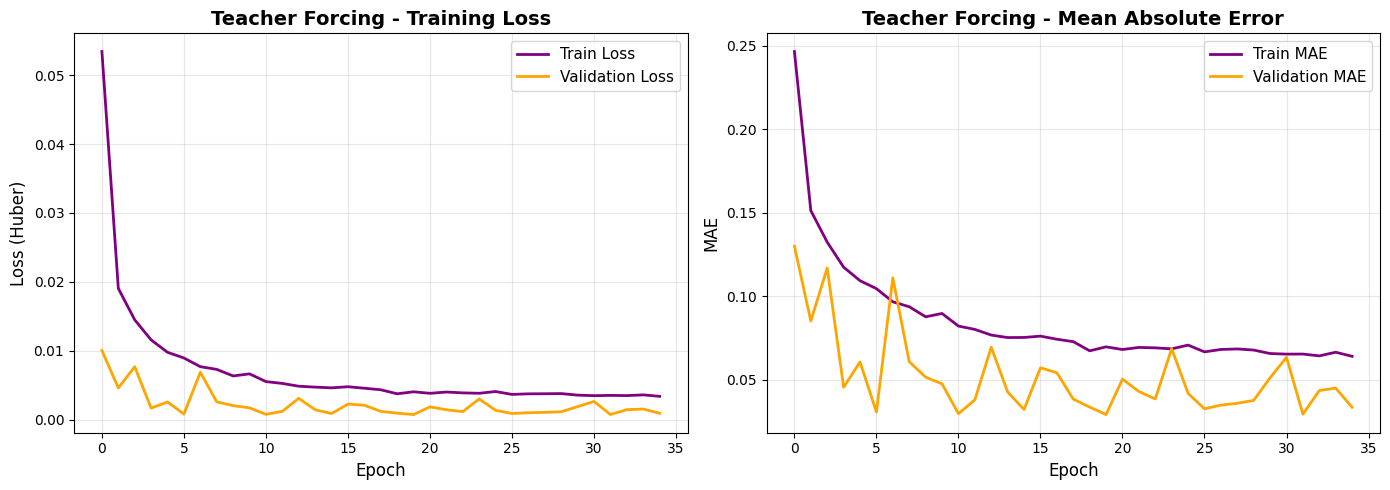

In [54]:
# Plot Teacher Forcing training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history_tf.history['loss'], label='Train Loss', linewidth=2, color='purple')
axes[0].plot(history_tf.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0].set_title('Teacher Forcing - Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Huber)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history_tf.history['mae'], label='Train MAE', linewidth=2, color='purple')
axes[1].plot(history_tf.history['val_mae'], label='Validation MAE', linewidth=2, color='orange')
axes[1].set_title('Teacher Forcing - Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
# Make predictions with Teacher Forcing model
print("Making Teacher Forcing predictions...")

# Predict on train data
train_predict_tf = model_tf.predict(X_train_tf, verbose=0)

# Predict on test data
test_predict_tf = model_tf.predict(X_test_tf, verbose=0)

# For comparison, we'll use the first prediction of each sequence
# (predicting the next immediate step, like the standard model)
train_predict_tf_1step = train_predict_tf[:, 0].reshape(-1, 1)
test_predict_tf_1step = test_predict_tf[:, 0].reshape(-1, 1)

# Inverse transform
train_predict_tf_prices = scaler.inverse_transform(train_predict_tf_1step)
test_predict_tf_prices = scaler.inverse_transform(test_predict_tf_1step)
y_train_tf_actual = scaler.inverse_transform(y_train_tf[:, 0].reshape(-1, 1))
y_test_tf_actual = scaler.inverse_transform(y_test_tf[:, 0].reshape(-1, 1))

print("Teacher Forcing predictions completed!")
print(f"Train predictions shape: {train_predict_tf_prices.shape}")
print(f"Test predictions shape: {test_predict_tf_prices.shape}")

Making Teacher Forcing predictions...
Teacher Forcing predictions completed!
Train predictions shape: (920, 1)
Test predictions shape: (239, 1)


In [56]:
# Calculate metrics for Teacher Forcing model
print("="*60)
print("TEACHER FORCING MODEL PERFORMANCE")
print("="*60)

train_metrics_tf = calculate_metrics(y_train_tf_actual, train_predict_tf_prices, "TRAIN SET (Teacher Forcing)")
test_metrics_tf = calculate_metrics(y_test_tf_actual, test_predict_tf_prices, "TEST SET (Teacher Forcing)")

print("\n" + "="*60)

TEACHER FORCING MODEL PERFORMANCE

TRAIN SET (Teacher Forcing) Metrics:
  RMSE: ₹28.27
  MAE:  ₹22.27
  MAPE: 2.19%
  R² Score: 0.9671

TEST SET (Teacher Forcing) Metrics:
  RMSE: ₹48.79
  MAE:  ₹40.84
  MAPE: 2.81%
  R² Score: 0.6454



### Comparison: Standard LSTM vs Teacher Forcing LSTM

Let's compare the two approaches side-by-side on the test set.

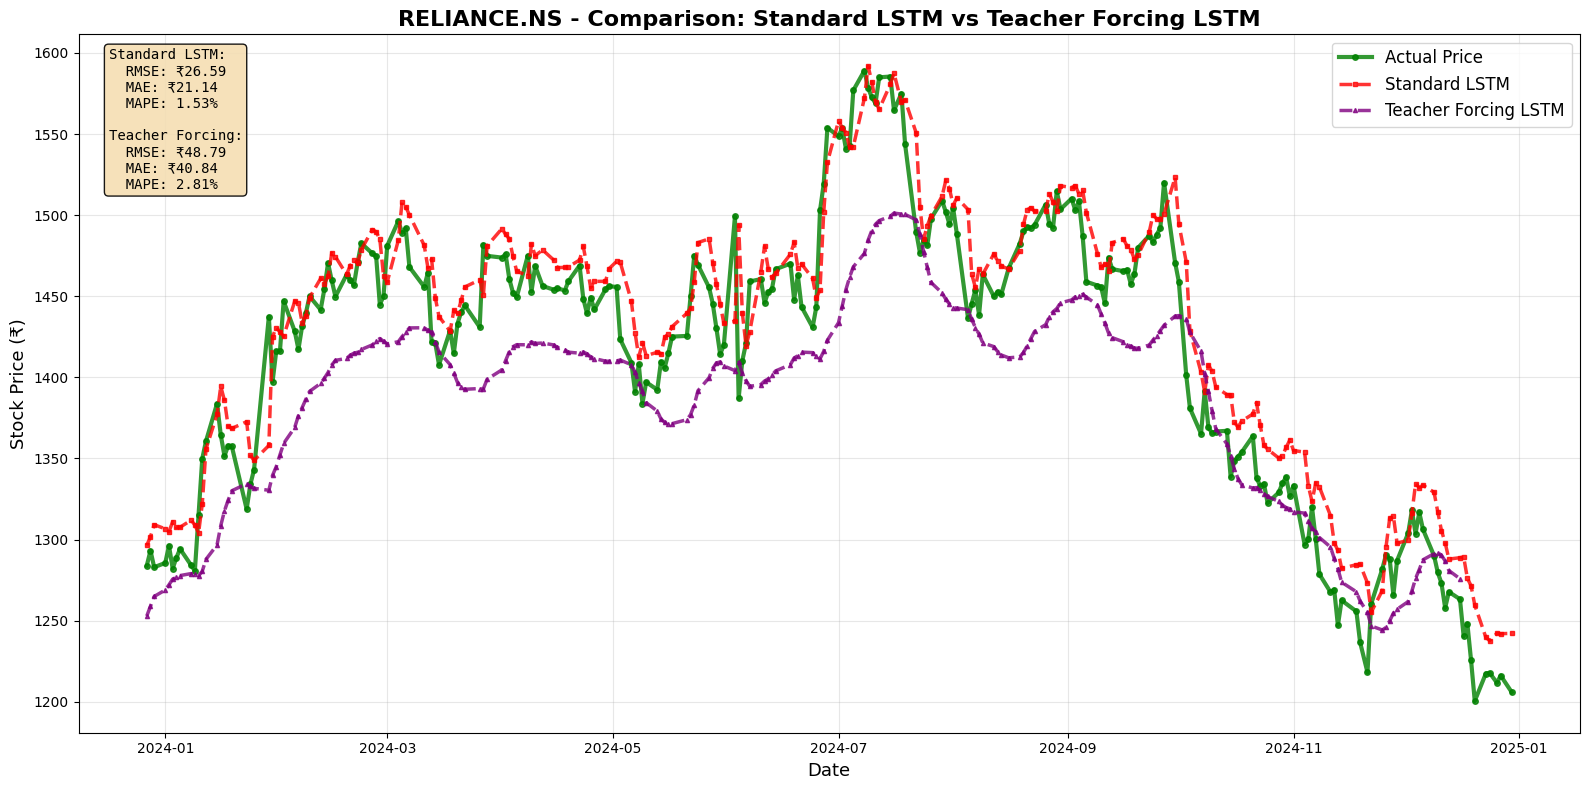

In [57]:
# Comparison Plot: Standard vs Teacher Forcing (Test Set)
plt.figure(figsize=(16, 8))

# Align the dates properly
# Standard model: uses all test dates
# Teacher Forcing: has fewer predictions due to horizon constraint
test_dates_standard = test_data.index
test_dates_tf = test_data.index[:len(test_predict_tf_prices)]

# Plot actual prices
plt.plot(test_data.index, test_data.values, label='Actual Price', 
         color='green', linewidth=3, alpha=0.8, marker='o', markersize=4)

# Plot standard LSTM predictions
plt.plot(test_dates_standard, test_predict, label='Standard LSTM', 
         color='red', linewidth=2.5, linestyle='--', marker='s', markersize=3, alpha=0.8)

# Plot teacher forcing predictions
plt.plot(test_dates_tf, test_predict_tf_prices, label='Teacher Forcing LSTM', 
         color='purple', linewidth=2.5, linestyle='--', marker='^', markersize=3, alpha=0.8)

plt.title(f'{TICKER} - Comparison: Standard LSTM vs Teacher Forcing LSTM', 
         fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Stock Price (₹)', fontsize=13)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with metrics comparison
textstr = f"Standard LSTM:\n  RMSE: ₹{test_metrics['rmse']:.2f}\n  MAE: ₹{test_metrics['mae']:.2f}\n  MAPE: {test_metrics['mape']:.2f}%\n\nTeacher Forcing:\n  RMSE: ₹{test_metrics_tf['rmse']:.2f}\n  MAE: ₹{test_metrics_tf['mae']:.2f}\n  MAPE: {test_metrics_tf['mape']:.2f}%"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

In [59]:
# Final Comparison Summary Table
print("\n" + "="*80)
print("FINAL COMPARISON: STANDARD LSTM vs TEACHER FORCING LSTM")
print("="*80)

comparison_data = {
    'Metric': ['RMSE (₹)', 'MAE (₹)', 'MAPE (%)', 'R² Score'],
    'Standard LSTM': [
        f"{test_metrics['rmse']:.2f}",
        f"{test_metrics['mae']:.2f}",
        f"{test_metrics['mape']:.2f}",
        f"{test_metrics['r2']:.4f}"
    ],
    'Teacher Forcing': [
        f"{test_metrics_tf['rmse']:.2f}",
        f"{test_metrics_tf['mae']:.2f}",
        f"{test_metrics_tf['mape']:.2f}",
        f"{test_metrics_tf['r2']:.4f}"
    ],
    'Improvement': [
        f"{((test_metrics['rmse'] - test_metrics_tf['rmse']) / test_metrics['rmse'] * 100):+.1f}%",
        f"{((test_metrics['mae'] - test_metrics_tf['mae']) / test_metrics['mae'] * 100):+.1f}%",
        f"{((test_metrics['mape'] - test_metrics_tf['mape']) / test_metrics['mape'] * 100):+.1f}%",
        f"{((test_metrics_tf['r2'] - test_metrics['r2']) / test_metrics['r2'] * 100):+.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
display(comparison_df)

# Winner determination
print("\n" + "="*80)
print("ANALYSIS:")
print("="*80)

if test_metrics_tf['rmse'] < test_metrics['rmse']:
    rmse_winner = "Teacher Forcing"
    rmse_improvement = (test_metrics['rmse'] - test_metrics_tf['rmse']) / test_metrics['rmse'] * 100
    print(f"✅ RMSE: Teacher Forcing wins by {rmse_improvement:.1f}% (Lower is better)")
else:
    rmse_winner = "Standard LSTM"
    rmse_degradation = (test_metrics_tf['rmse'] - test_metrics['rmse']) / test_metrics['rmse'] * 100
    print(f"✅ RMSE: Standard LSTM wins by {rmse_degradation:.1f}% (Lower is better)")

if test_metrics_tf['mape'] < test_metrics['mape']:
    mape_winner = "Teacher Forcing"
    mape_improvement = (test_metrics['mape'] - test_metrics_tf['mape']) / test_metrics['mape'] * 100
    print(f"✅ MAPE: Teacher Forcing wins by {mape_improvement:.1f}% (Lower is better)")
else:
    mape_winner = "Standard LSTM"
    mape_degradation = (test_metrics_tf['mape'] - test_metrics['mape']) / test_metrics['mape'] * 100
    print(f"✅ MAPE: Standard LSTM wins by {mape_degradation:.1f}% (Lower is better)")

if test_metrics_tf['r2'] > test_metrics['r2']:
    r2_winner = "Teacher Forcing"
    r2_improvement = (test_metrics_tf['r2'] - test_metrics['r2']) / test_metrics['r2'] * 100
    print(f"✅ R²: Teacher Forcing wins by {r2_improvement:.1f}% (Higher is better)")
else:
    r2_winner = "Standard LSTM"
    r2_degradation = (test_metrics['r2'] - test_metrics_tf['r2']) / test_metrics['r2'] * 100
    print(f"✅ R²: Standard LSTM wins by {r2_degradation:.1f}% (Higher is better)")

print("\n" + "="*80)
print("CONCLUSION:")

# Count wins
tf_wins = sum([1 for winner in [rmse_winner, mape_winner, r2_winner] if winner == "Teacher Forcing"])
standard_wins = 3 - tf_wins

if tf_wins > standard_wins:
    print(f"🏆 Overall Winner: TEACHER FORCING LSTM ({tf_wins}/3 metrics)")
    print("   Teacher Forcing provides better multi-step ahead predictions.")
elif standard_wins > tf_wins:
    print(f"🏆 Overall Winner: STANDARD LSTM ({standard_wins}/3 metrics)")
    print("   Standard approach performs better for this dataset.")
else:
    print("🤝 TIE: Both approaches perform similarly.")

print("\nKey Insights:")
print("• Teacher Forcing trains on multi-step sequences, useful for longer horizons")
print("• Standard LSTM is simpler and often sufficient for single-step predictions")
print("• Choice depends on prediction horizon and data characteristics")
print("="*80)


FINAL COMPARISON: STANDARD LSTM vs TEACHER FORCING LSTM

Test Set Performance:


,Metric,Standard LSTM,Teacher Forcing,Improvement
0,RMSE (₹),26.59,48.79,-83.5%
1,MAE (₹),21.14,40.84,-93.2%
2,MAPE (%),1.53,2.81,-84.2%
3,R² Score,0.9103,0.6454,-29.1%



ANALYSIS:
✅ RMSE: Standard LSTM wins by 83.5% (Lower is better)
✅ MAPE: Standard LSTM wins by 84.2% (Lower is better)
✅ R²: Standard LSTM wins by 29.1% (Higher is better)

CONCLUSION:
🏆 Overall Winner: STANDARD LSTM (3/3 metrics)
   Standard approach performs better for this dataset.

Key Insights:
• Teacher Forcing trains on multi-step sequences, useful for longer horizons
• Standard LSTM is simpler and often sufficient for single-step predictions
• Choice depends on prediction horizon and data characteristics
